# 2020 Presidential Election Time Series
## Project Setup

In [34]:
%run get_data.py

Repo: 'origin': https://github.com/ElectProject/Early-Vote-2020G.git
Total commits: 1400
docs/index.html commits: 635


,commit,datetime,vote_id,vote_total,request_id,request_total
1,29ccc6de6b829e970ebd0a795c2ab7a99f15e1b6,2020-11-02 21:40:00-05:00,total-voted,98708297,mail-ballots-requested,92090788
2,532eb8e7944a0702ab6703d69a685b8a5f4eeb76,2020-11-02 21:15:00-05:00,total-voted,98440077,mail-ballots-requested,92082158
3,fd3e9e8e89cc489c8bc462fce924c387079d4af1,2020-11-02 20:40:00-05:00,total-voted,98423113,mail-ballots-requested,92083611
4,4284aeddd236f666bcc09a2a77088ba36fd3477e,2020-11-02 20:23:00-05:00,total-voted,98169959,mail-ballots-requested,92078788
6,b08bbf24ca702e2afcc2de328fac088de8b40611,2020-11-02 19:21:00-05:00,total-voted,97930638,mail-ballots-requested,92080792
...,...,...,...,...,...,...
630,55ef4d8da4c860460a99cff8d2e7dac0605a857d,2020-09-01 22:55:00-04:00,NaN,NaN,NaN,12743272
631,ff3f92d8e11b8a23335cddf64e5799c74912ec52,2020-09-01 22:08:00-04:00,NaN,NaN,NaN,12623324
632,52ba37e4bd3605ab83b71358536ddf26d54b395d,2020-09-01 20:43:00-04:00,NaN,NaN,national-statistics,12623324
633,d34181643d565305eff7486090acbe9329c48d31,2020-09-01 15:48:00-04:00,NaN,NaN,national-statistics,12623324


,datetime,vote_total_2016
0,2020-09-25 22:59:00-04:00,9525
1,2020-10-02 22:59:00-04:00,74836
2,2020-10-09 22:59:00-04:00,429337
3,2020-10-16 22:59:00-04:00,1400000
4,2020-10-23 22:59:00-04:00,5900000
5,2020-10-30 22:59:00-04:00,21000000
6,2020-11-02 22:59:00-05:00,46220922
7,2020-11-03 22:59:00-05:00,136452150


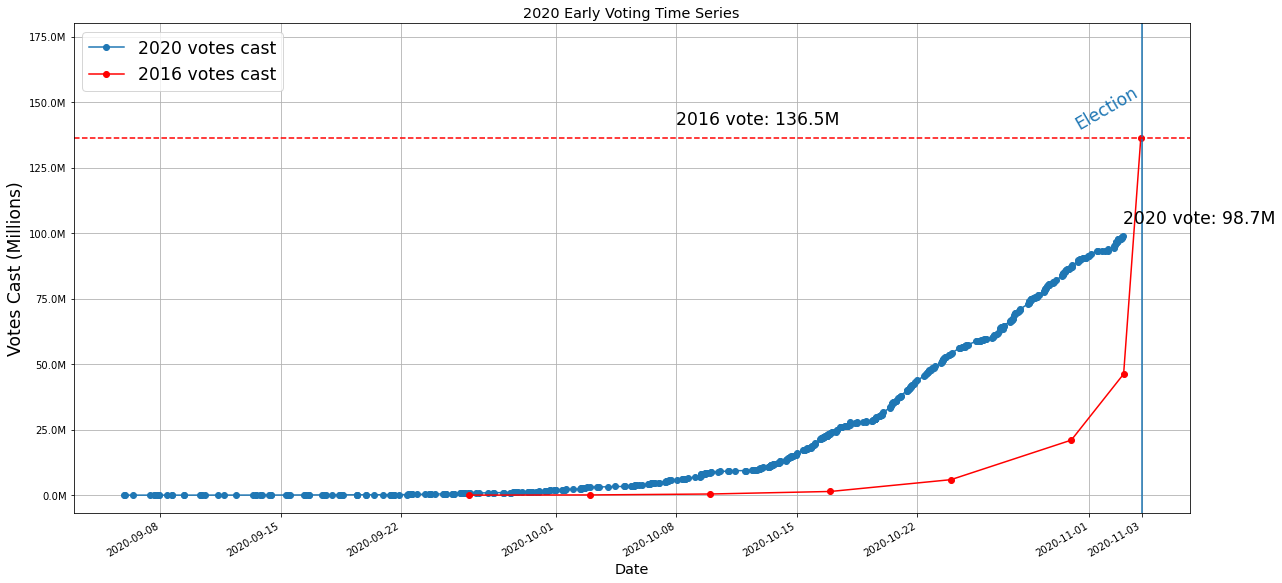

Loading BokehJS ...

In [35]:
update_notebook()